Loading relevant packages

In [1]:
import requests
import json
from json import loads
import pandas as pd
from datetime import datetime
import time
import loading
import util
import processing
import importlib
import itertools
importlib.reload(loading)
importlib.reload(util)
importlib.reload(processing)

/Users/jeremyelvander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<module 'processing' from '/Users/jeremyelvander/STA-141B-Final-Project/processing.py'>

Using BART API to find relevant station information (Station name, Lattitude & Longitude for mapping)

In [2]:
df = loading.stationLoad(["San Francisco", "Oakland"])

In [3]:
stationInfo = util.Rename(df, {"name":"station"})

In [37]:
df

,city,name,gtfs_latitude,gtfs_longitude
0,Oakland,12th St. Oakland City Center,37.803768,-122.271450
1,Oakland,Oakland International Airport,37.713238,-122.212191
2,Oakland,MacArthur,37.829065,-122.267040
3,Oakland,Lake Merritt,37.797027,-122.265180
4,Oakland,Rockridge,37.844702,-122.251371
5,Oakland,Coliseum,37.753661,-122.196869
6,Oakland,Fruitvale,37.774836,-122.224175
7,Oakland,19th St. Oakland,37.808350,-122.268602
8,Oakland,West Oakland,37.804872,-122.295140
9,San Francisco,Embarcadero,37.792874,-122.397020


In [4]:

dct = util.dfToDict(df, 'name', ['gtfs_latitude', 'gtfs_longitude'], groupby = 'city')
print(dct)
dct['San Francisco']['Balboa Park']

{'Oakland': {'12th St. Oakland City Center': [37.803768, -122.27145], '19th St. Oakland': [37.80835, -122.268602], 'Coliseum': [37.753661, -122.196869], 'Fruitvale': [37.774836, -122.224175], 'Lake Merritt': [37.797027, -122.26518], 'MacArthur': [37.829065, -122.26704], 'Oakland International Airport': [37.713238, -122.212191], 'Rockridge': [37.844702, -122.251371], 'West Oakland': [37.804872, -122.29514]}, 'San Francisco': {'16th St. Mission': [37.765062, -122.419694], '24th St. Mission': [37.75247, -122.418143], 'Balboa Park': [37.721585, -122.447506], 'Civic Center/UN Plaza': [37.779732, -122.414123], 'Embarcadero': [37.792874, -122.39702], 'Glen Park': [37.733064, -122.433817], 'Montgomery St.': [37.789405, -122.401066], 'Powell St.': [37.784471, -122.407974]}}


[37.721585, -122.447506]

In [5]:
secretKey = '1ef8dner8br348ez190z3z188a6pm1yluwh2wcj4xjjnlvupe'
key = '523e7ewewudxb1frvbmdftwdt'

In [11]:
importlib.reload(processing)
importlib.reload(util)
queriesSF = [
            ['SF', dct['San Francisco']['Balboa Park'], 0.25, 2021, 1000, 0],
             ['SF', dct['San Francisco']['Embarcadero'], 0.25, 2021, 1000, 0],
             ['SF', dct['San Francisco']['Glen Park'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Civic Center/UN Plaza'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['24th St. Mission'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Montgomery St.'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['16th St. Mission'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Powell St.'], 0.25, 2021, 1000, 0]]

metaSF = [
    [['incident_category', "SF"],
    ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
    ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Balboa Park"},
    ["San Francisco", "Balboa Park", dct]],
 [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Embarcadero"},
    ["San Francisco", "Embarcadero", dct]],
[['incident_category', "SF"],
["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Glen Park"},
    ["San Francisco", "Glen Park", dct]],
 [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Civic Center/UN Plaza"},
    ["San Francisco", "Civic Center/UN Plaza", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "24th St. Mission"},
    ["San Francisco", "24th St. Mission", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Montgomery St."},
    ["San Francisco", "Montgomery St.", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "16th St. Mission"},
    ["San Francisco", "16th St. Mission", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Powell St."},
    ["San Francisco", "Powell St.", dct]]
]

subprocessesSF = [
    util.isViolent, 
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesSF)

queriesOAK = [
             ['OAK', dct['Oakland']['Fruitvale'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['Rockridge'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['MacArthur'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Coliseum'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['12th St. Oakland City Center'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Oakland International Airport'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Lake Merritt'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['19th St. Oakland'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['West Oakland'], 0.25, 2021, 1000, 0]
            ]

metaOAK = [
    [
        ['description', "OAK"],
    ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
        ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Fruitvale"},
    ["Oakland", "Fruitvale", dct]],
 [
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Rockridge"},
    ["Oakland", "Rockridge", dct]],
[
    ['description', "OAK"],
["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "MacArthur"},
    ["Oakland", "MacArthur", dct]],
 [
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Coliseum"},
    ["Oakland", "Coliseum", dct]],
    [
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "12th St. Oakland City Center"},
    ["Oakland", "12th St. Oakland City Center", dct]],
    [
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Oakland International Airport"},
    ["Oakland", "Oakland International Airport", dct]],
    [
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Lake Merritt"},
    ["Oakland", "Lake Merritt", dct]],
    [
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "19th St. Oakland"},
    ["Oakland", "19th St. Oakland", dct]],
    [
        ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "West Oakland"},
    ["Oakland", "West Oakland", dct]]
]

subprocessesOAK = [
    util.isViolent, 
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesOAK)

processes = [
    [processing.parallelProcess, [10, loading.loadCrime, queriesSF, 
                                       'crime', True, None, subprocessesSF,
                                       metaSF, key, secretKey]],
    [processing.parallelProcess, [10, loading.loadCrime, queriesOAK, 
                                       'crime', True, None, subprocessesOAK,
                                       metaOAK, key, secretKey]]
]

In [12]:
results = processing.multiParallelProcess(2, processes)

Time taken to process (seconds): 42.47479510307312
Time taken to process (seconds): 112.30989098548889


In [9]:
frame, thru, time = processing.parallelProcess(10, loading.loadCrime, queriesSF, 
                                       'crime', True, 20, subprocessesSF,
                                       metaSF, key, secretKey)
frame

[{'incident_datetime': '2021-01-06T15:00:00.000', 'incident_category': 'Burglary', 'point': {'type': 'Point', 'coordinates': [-122.39695784020824, 37.796346859010335]}}, {'incident_datetime': '2021-01-07T05:50:00.000', 'incident_category': 'Motor Vehicle Theft', 'point': {'type': 'Point', 'coordinates': [-122.39650448774395, 37.79309708139333]}}, {'incident_datetime': '2021-01-07T06:55:00.000', 'incident_category': 'Non-Criminal', 'point': {'type': 'Point', 'coordinates': [-122.39668969554637, 37.79046106747903]}}, {'incident_datetime': '2021-01-08T15:00:00.000', 'incident_category': 'Assault', 'point': {'type': 'Point', 'coordinates': [-122.3931813328012, 37.79323049132005]}}, {'incident_datetime': '2021-01-09T17:45:00.000', 'incident_category': 'Larceny Theft', 'point': {'type': 'Point', 'coordinates': [-122.39695784020824, 37.796346859010335]}}, {'incident_datetime': '2021-01-10T00:30:00.000', 'incident_category': 'Burglary', 'point': {'type': 'Point', 'coordinates': [-122.399763354

,incident_category,isViolent,night,longitude,latitude,date,time,city,station,distance
0,Larceny Theft,False,False,-122.444501,37.721096,2021-02-01,16:30:00.000,San Francisco,Balboa Park,0.208406
1,Other Miscellaneous,False,False,-122.443793,37.722240,2021-02-03,18:49:00.000,San Francisco,Balboa Park,0.257691
2,Recovered Vehicle,False,False,-122.443793,37.722240,2021-02-05,17:52:00.000,San Francisco,Balboa Park,0.257691
3,Other Miscellaneous,False,False,-122.443793,37.722240,2021-02-05,17:52:00.000,San Francisco,Balboa Park,0.257691
4,Drug Offense,False,False,-122.443793,37.722240,2021-02-05,17:52:00.000,San Francisco,Balboa Park,0.257691
...,...,...,...,...,...,...,...,...,...,...
155,Robbery,True,True,-122.410292,37.782231,2021-01-03,02:00:00.000,San Francisco,Powell St.,0.180376
156,Fraud,False,False,-122.408709,37.780971,2021-01-03,08:00:00.000,San Francisco,Powell St.,0.139188
157,Non-Criminal,False,False,-122.408952,37.783288,2021-01-03,08:35:00.000,San Francisco,Powell St.,0.080544
158,Suspicious Occ,False,False,-122.408493,37.784453,2021-01-03,14:41:00.000,San Francisco,Powell St.,0.035877


In [29]:
importlib.reload(processing)
importlib.reload(util)
importlib.reload(loading)


reviewQuery = [
    ['https://www.yelp.com/biz/muni-bart-station-embarcadero-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/muni-bart-station-montgomery-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-muni-powell-street-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/muni-bart-station-civic-center-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-16th-st-mission-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-24th-st-mission-station-san-francisco-2?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-glen-park-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-balboa-park-station-san-francisco?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-west-oakland-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-12th-street-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-19th-street-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-macarthur-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-rockridge-station-oakland-2?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-fruitvale-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-coliseum-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-lake-merritt-station-oakland?sort_by=date_desc', True],
    ['https://www.yelp.com/biz/bart-oakland-international-airport-station-oakland-2?sort_by=date_desc', True]
]

subprocessesReview = [
    util.reviewStationDict,
    util.getCompoundSentiment]* len(reviewQuery)

metaReview = [
    [['San Francisco', 'Embarcadero'],
     ['reviews']],
    [["San Francisco", "Montgomery St."],
     ['reviews']],
    [["San Francisco", "Powell St."],
     ['reviews']],
    [["San Francisco", "Civic Center/UN Plaza"],
     ['reviews']],
    [["San Francisco", "16th St. Mission"],
     ['reviews']],
    [["San Francisco", "24th St. Mission"],
     ['reviews']],
    [["San Francisco", "Glen Park"],
     ['reviews']],
    [["San Francisco", "Balboa Park"],
     ['reviews']],
    [["Oakland", "West Oakland"],
     ['reviews']],
    [["Oakland", "12th St. Oakland City Center"],
     ['reviews']],
    [["Oakland", "19th St. Oakland"],
     ['reviews']],
    [["Oakland", "MacArthur"],
     ['reviews']],
    [["Oakland", "Rockridge"],
     ['reviews']],
    [["Oakland", "Fruitvale"],
     ['reviews']],
    [["Oakland", "Coliseum"],
     ['reviews']],
    [["Oakland", "Lake Merritt"],
     ['reviews']],
    [["Oakland", "Oakland International Airport"],
     ['reviews']]
]

frame, thru, time = processing.parallelProcess(10, loading.GetReviews, reviewQuery, 
                                       'review', True, None, subprocessesReview, metaReview)
frame

done with visit list!
got da reviews
done with visit list!
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
review page done
review page done
done with visit list!
review page done
got da reviews
review page done
review page done
review page done
got da reviews
got da reviews
review page done
review page done
review page done
review page done
done with visit list!
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done
review page done

,city,station,overallSentiment
0,San Francisco,Embarcadero,0.104858
1,San Francisco,Montgomery St.,0.170156
2,San Francisco,Powell St.,0.154613
3,San Francisco,Civic Center/UN Plaza,0.087766
4,San Francisco,16th St. Mission,0.043115
5,San Francisco,24th St. Mission,0.099162
6,San Francisco,Glen Park,0.339844
7,San Francisco,Balboa Park,0.116380
8,Oakland,West Oakland,0.000000
9,Oakland,12th St. Oakland City Center,0.102694


In [10]:

results = processing.multiParallelProcess(2, processes)

Time taken to process (seconds): 5.642333030700684
Time taken to process (seconds): 5.793116092681885


In [13]:
display(results[0][0].sample(5))
display(results[1][0].sample(5))

,incident_category,isViolent,night,longitude,latitude,date,time,city,station,distance
63611,Warrant,False,False,-122.408493,37.784453,2022-05-13,12:12:00.000,San Francisco,Powell St.,0.035877
63606,Larceny Theft,False,False,-122.407337,37.784560,2022-05-13,10:01:00.000,San Francisco,Powell St.,0.044134
35047,Other Miscellaneous,False,False,-122.418288,37.750640,2023-05-16,07:33:00.000,San Francisco,24th St. Mission,0.068533
12744,Robbery,True,True,-122.412617,37.777026,2022-01-16,00:50:00.000,San Francisco,Civic Center/UN Plaza,0.144476
50221,Larceny Theft,False,False,-122.424103,37.764783,2023-02-05,11:50:00.000,San Francisco,16th St. Mission,0.304789


,description,isViolent,night,longitude,latitude,date,time,city,station,distance
8455,burglary auto,False,False,-122.26928,37.80493,2021-05-08,18:00:00.000,Oakland,12th St. Oakland City Center,0.155942
23573,vandalism,False,False,-122.26735,37.81165,2023-09-19,18:00:00.000,Oakland,19th St. Oakland,0.149337
9598,willful discharge firearm in negligent manner,False,False,-122.27446,37.80626,2022-01-08,20:19:00.000,Oakland,12th St. Oakland City Center,0.227388
23756,grand theft,False,False,-122.26572,37.80594,2023-10-13,09:30:00.000,Oakland,19th St. Oakland,0.218072
25557,obstruct/resist/etc public/peace officer/emerg...,False,False,-122.29197,37.80584,2021-02-01,10:49:00.000,Oakland,West Oakland,0.221924


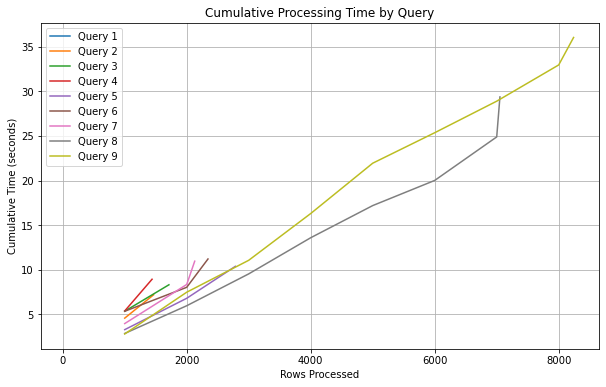

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

# Sample data
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = results[1][1]

# Number of queries
num_queries = len(data)

# Initialize storage for cumulative times and rows processed
cumulative_times = []
cumulative_rows = []

# Process each query
for query in data:
    # Extract processing times and rows processed for this query
    times = [entry[0] for entry in query]
    rows = [entry[1] for entry in query]

    # Calculate cumulative time and rows
    cumulative_times.append(np.cumsum(times))
    cumulative_rows.append(np.cumsum(rows))

# Plotting
plt.figure(figsize=(10, 6))

# Plot cumulative time for each query
for query_idx in range(num_queries):
    plt.plot(cumulative_rows[query_idx], cumulative_times[query_idx], label=f"Query {query_idx + 1}")

# Add labels, legend, and grid
plt.title("Cumulative Processing Time by Query")
plt.xlabel("Rows Processed")
plt.ylabel("Cumulative Time (seconds)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [15]:
names = {"incident_datetime": "datetime", "incident_category": "crime", "description": "crime"}
sfFrame =  util.Rename(results[0][0], names)
oakFrame = util.Rename(results[1][0], names)

crimeData = pd.concat([sfFrame, oakFrame], ignore_index = True)
crimeData['date'] = pd.to_datetime(crimeData['date']).dt.normalize()
crimeData['year'] = crimeData['date'].dt.year
crimeData['month'] = crimeData['date'].dt.month
crimeData['time'] = pd.to_datetime(crimeData['time']).dt.time
crimeData.sample(5)

,crime,isViolent,night,longitude,latitude,date,time,city,station,distance,year,month
50112,Other Miscellaneous,False,False,-122.418271,37.761902,2023-01-18,19:01:00,San Francisco,16th St. Mission,0.152865,2023,1
89255,murder first degree,True,False,-122.267170,37.803610,2022-07-15,21:00:00,Oakland,12th St. Oakland City Center,0.295780,2022,7
33019,Other Miscellaneous,False,False,-122.415172,37.752440,2022-04-15,22:45:00,San Francisco,24th St. Mission,0.205262,2022,4
15262,Lost Property,False,False,-122.413487,37.779992,2022-06-26,15:00:00,San Francisco,Civic Center/UN Plaza,0.044957,2022,6
9425,Larceny Theft,False,False,-122.412158,37.776661,2021-05-31,00:00:00,San Francisco,Civic Center/UN Plaza,0.177117,2021,5


In [16]:
# crimeData.groupby('station').size().reset_index(name = 'Number of Crimes')

result = (
    crimeData.groupby("station")
    .agg(
        crimes_per_station=("crime", "size"),  # Number of crimes per station
        most_common_crime=("crime", lambda x: x.mode()[0]),  # Most common crime
        percent_night=("night", lambda x: x.mean()),  # % crimes at night
        percent_violent=("isViolent", lambda x: x.mean()),  # % violent crimes
        avg_distance=("distance", "mean"),  # Average distance
    )
    .reset_index()
)
display(result)

,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance
0,12th St. Oakland City Center,7052,burglary auto,0.090613,0.119682,0.156881
1,16th St. Mission,11610,Larceny Theft,0.100947,0.158398,0.124149
2,19th St. Oakland,8240,burglary auto,0.087621,0.090534,0.147863
3,24th St. Mission,6695,Larceny Theft,0.105601,0.188051,0.120314
4,Balboa Park,897,Larceny Theft,0.111483,0.131550,0.158883
5,Civic Center/UN Plaza,23728,Drug Offense,0.074258,0.125464,0.133701
6,Coliseum,1466,vehicle theft auto,0.090723,0.114598,0.125511
7,Embarcadero,5251,Larceny Theft,0.055799,0.106646,0.146733
8,Fruitvale,2785,vehicle theft auto,0.109156,0.237702,0.147797
9,Glen Park,1264,Larceny Theft,0.079905,0.072785,0.140189


In [17]:
result = (
    crimeData.groupby(['year', 'month', 'station'])
    .agg(
        crimes_per_station=("crime", "size"),  # Number of crimes per station
        most_common_crime=("crime", lambda x: x.mode()[0]),  # Most common crime
        percent_night=("night", lambda x: x.mean()),  # % crimes at night
        percent_violent=("isViolent", lambda x: x.mean()),  # % violent crimes
        avg_distance=("distance", "mean"),  # Average distance
    )
    .reset_index()
)

result['year_month'] = (
    result['year'].astype(str) + '-' + result['month'].astype(str).str.zfill(2)
)

display(result.sample(5))

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month
620,2024,2,19th St. Oakland,111,burglary auto,0.153153,0.099099,0.144010,2024-02
669,2024,5,12th St. Oakland City Center,99,burglary auto,0.131313,0.181818,0.153593,2024-05
580,2023,11,Oakland International Airport,3,embezzle leased/rented vehicle,0.000000,0.000000,0.068482,2023-11
17,2021,2,16th St. Mission,190,Other Miscellaneous,0.089474,0.094737,0.118530,2021-02
638,2024,3,24th St. Mission,135,Assault,0.059259,0.251852,0.119074,2024-03


<Figure size 864x432 with 0 Axes>

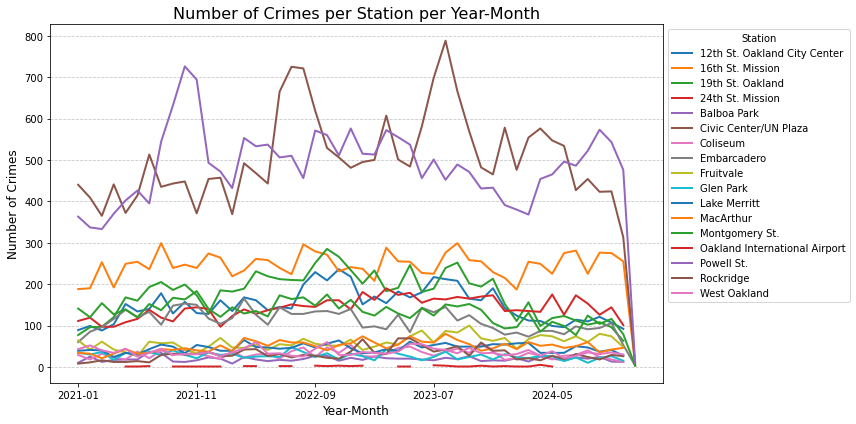

In [18]:
import matplotlib.pyplot as plt

# Pivot the data to have stations as columns and year_month as rows
crime_summary = result.pivot(index='year_month', columns='station', values='crimes_per_station')

# Plot the data
plt.figure(figsize=(12, 6))
crime_summary.plot(linewidth=2, figsize=(12, 6))
plt.title('Number of Crimes per Station per Year-Month', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Station', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [19]:
merged = pd.merge(stationInfo, result, on="station")
merged.shape

(788, 12)

In [24]:
# Generate full combinations of years, months, and stations
years = merged["year"].unique()
months = range(1, 13)  # 12 months
stations = merged["station"].unique()
all_combinations = pd.DataFrame(list(itertools.product(years, months, stations)), columns=["year", "month", "station"])

station_info = merged.drop_duplicates(subset=["station"])[["station", "city", "gtfs_latitude", "gtfs_longitude"]]
all_combinations = all_combinations.merge(station_info, on="station", how="left")

# Merge with the original DataFrame
geoCrimeFrame = all_combinations.merge(merged, on=["year", "month", "station"], how="left")

geoCrimeFrame["city"] = geoCrimeFrame["city_x"].combine_first(geoCrimeFrame["city_y"])
geoCrimeFrame["gtfs_latitude"] = geoCrimeFrame["gtfs_latitude_x"].combine_first(geoCrimeFrame["gtfs_latitude_y"])
geoCrimeFrame["gtfs_longitude"] = geoCrimeFrame["gtfs_longitude_x"].combine_first(geoCrimeFrame["gtfs_longitude_y"])

# Drop the now-redundant columns
geoCrimeFrame.drop(columns=["city_x", "city_y", "gtfs_latitude_x", "gtfs_latitude_y", "gtfs_longitude_x", "gtfs_longitude_y"], inplace=True)

# Fill missing values
geoCrimeFrame["crimes_per_station"].fillna(0, inplace=True)
geoCrimeFrame["most_common_crime"].fillna("None", inplace=True)  # No crime reported
geoCrimeFrame["percent_night"].fillna(0, inplace=True)
geoCrimeFrame["percent_violent"].fillna(0, inplace=True)
geoCrimeFrame["avg_distance"].fillna(0, inplace=True)

# Recreate 'year_month' column
geoCrimeFrame["year_month"] = geoCrimeFrame["year"].astype(str) + "-" + geoCrimeFrame["month"].astype(str).str.zfill(2)

# Sort the DataFrame by year, month, and station
geoCrimeFrame.sort_values(by=["year", "month", "station"], inplace=True)

# Reset index
geoCrimeFrame.reset_index(drop=True, inplace=True)

display(geoCrimeFrame)

,year,month,station,crimes_per_station,most_common_crime,percent_night,percent_violent,avg_distance,year_month,city,gtfs_latitude,gtfs_longitude
0,2021,1,12th St. Oakland City Center,89.0,burglary auto,0.067416,0.191011,0.142277,2021-01,Oakland,37.803768,-122.271450
1,2021,1,16th St. Mission,188.0,Other Miscellaneous,0.111702,0.154255,0.125892,2021-01,San Francisco,37.765062,-122.419694
2,2021,1,19th St. Oakland,77.0,burglary auto,0.038961,0.064935,0.127915,2021-01,Oakland,37.808350,-122.268602
3,2021,1,24th St. Mission,111.0,Burglary,0.072072,0.090090,0.122344,2021-01,San Francisco,37.752470,-122.418143
4,2021,1,Balboa Park,10.0,Larceny Theft,0.000000,0.000000,0.156588,2021-01,San Francisco,37.721585,-122.447506
...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024,12,Montgomery St.,3.0,Assault,0.666667,0.666667,0.147482,2024-12,San Francisco,37.789405,-122.401066
812,2024,12,Oakland International Airport,0.0,None,0.000000,0.000000,0.000000,2024-12,Oakland,37.713238,-122.212191
813,2024,12,Powell St.,11.0,Larceny Theft,0.000000,0.090909,0.139793,2024-12,San Francisco,37.784471,-122.407974
814,2024,12,Rockridge,0.0,None,0.000000,0.000000,0.000000,2024-12,Oakland,37.844702,-122.251371


In [ ]:
#Adding ridership to geoCrimeFrame! 
sfStationList = [
    'Embarcadero', 'Balboa Park', 'Glen Park', '24th St. Mission', 'Montgomery St.',
    '16th St. Mission', 'Powell St.', 'Civic Center/UN Plaza'
]
twoLetterCode = ['12', 'OA', 'MA', 'LM', 'RR', 'CL', 'FV', '19', 'OW', 
                 'EM', 'BP' 'GP', '24', 'MT', '16', 'PL', 'CC']



ridership = [117882, 34783+36653, 18860+18446, 38733+39824, 66704+54339, 38834+39024, 98746+83480, 61280+66608,
             2974+2662, 1661+1514, 892+837, 1749+1792, 2740+3305, 1784+1774, 4299+3617, 3117+2860]

In [82]:
import os
# Folder paths and constants
base_folder = "ridership"
years = [2021, 2022, 2023, 2024]
sheet_names = {2021: "Total Trips OD", 2022: "Total Trips OD", 2023: "Total Trips OD", 2024: "Total Trips"}
two_letter_codes = ['12', 12, 'OA', 'MA', 'LM', 'RR', 'CL', 'FV', '19', 19, 'OW', 
                    'EM', 'BP', 'GP', '24', 24, 'MT', '16', 16, 'PL', 'CC']

# Initialize an empty DataFrame for results
result_df = pd.DataFrame(columns=["year", "month", "year_month", "station", "ridership"])

# Loop through each year and month
for year in years:
    year_folder = os.path.join(base_folder, f"ridership_{year}")
    for month in range(1, 13):
        file_name = f"Ridership_{year}{str(month).zfill(2)}.xlsx"
        file_path = os.path.join(year_folder, file_name)

        # Read the file from the repository (local relative path)
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        # Read the appropriate sheet from the Excel file
        sheet_name = sheet_names[year]
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        # Adjust data based on year-specific conditions
        if year in [2021, 2022, 2023]:
            df = df.iloc[1:-1]  # Ignore the first row and the last row
            station_col = "Exit stations"
            ridership_col = df.columns[-1]  # Last column
        elif year == 2024:
            df = df.iloc[4:-1]  # Ignore the first four rows and the last row
            station_col = "Total Trip OD"
            ridership_col = df.columns[-1]  # Last column
        else:
            print(f"Year {year} not supported.")
            continue

        # Filter for rows with valid station codes
        if station_col not in df.columns or ridership_col not in df.columns:
            print(f"Could not locate required columns in {file_path}")
            continue

        filtered_df = df[df[station_col].isin(two_letter_codes)].copy()

        # Create the year, month, and year_month columns
        filtered_df.loc[:, "year"] = year
        filtered_df.loc[:, "month"] = month
        filtered_df.loc[:, "year_month"] = f"{year}-{str(month).zfill(2)}"

        # Select and rename columns
        filtered_df = filtered_df[["year", "month", "year_month", station_col, ridership_col]]
        filtered_df.columns = ["year", "month", "year_month", "station", "ridership"]

        # Append to the result DataFrame
        result_df = pd.concat([result_df, filtered_df], ignore_index=True)

# Extend data for missing months
for station in two_letter_codes:
    for month in [11, 12]:  # Months to fill for 2024
        if not ((result_df["year"] == 2024) & (result_df["month"] == month) & (result_df["station"] == station)).any():
            # Get data from the previous available month
            prev_data = result_df[(result_df["year"] == 2024) & (result_df["month"] == month - 1) & (result_df["station"] == station)]
            if not prev_data.empty:
                new_row = prev_data.iloc[0].copy()
                new_row["month"] = month
                new_row["year_month"] = f"2024-{str(month).zfill(2)}"
                result_df = pd.concat([result_df, pd.DataFrame([new_row])], ignore_index=True)

File not found: ridership/ridership_2024/Ridership_202411.xlsx
File not found: ridership/ridership_2024/Ridership_202412.xlsx


In [83]:

# Display the final DataFrame
display(result_df)

,year,month,year_month,station,ridership
0,2021,1,2021-01,MA,24838.0
1,2021,1,2021-01,19,21718.0
2,2021,1,2021-01,12,27587.0
3,2021,1,2021-01,LM,21843.0
4,2021,1,2021-01,FV,42621.0
...,...,...,...,...,...
811,2024,12,2024-12,16,162851.0
812,2024,11,2024-11,PL,323917.0
813,2024,12,2024-12,PL,323917.0
814,2024,11,2024-11,CC,256853.0


In [26]:
df['name']

0      12th St. Oakland City Center
1     Oakland International Airport
2                         MacArthur
3                      Lake Merritt
4                         Rockridge
5                          Coliseum
6                         Fruitvale
7                  19th St. Oakland
8                      West Oakland
9                       Embarcadero
10                      Balboa Park
11                        Glen Park
12                 24th St. Mission
13                   Montgomery St.
14                 16th St. Mission
15                       Powell St.
16            Civic Center/UN Plaza
Name: name, dtype: object

In [25]:
import plotly.express as px

geoCrimeFrame["scaled_crimes"] = geoCrimeFrame["crimes_per_station"] ** 0.5 
fig = px.scatter_mapbox(
    geoCrimeFrame,
    lat="gtfs_latitude",
    lon="gtfs_longitude",
    size="crimes_per_station",
    color="station",
    animation_frame="year_month",  # Animation over time
    hover_name="station",
    hover_data={"crimes_per_station": True, "most_common_crime": True, "percent_night": True, 
                "percent_violent": True, "avg_distance": True, "gtfs_latitude": False, "gtfs_longitude": False},
    mapbox_style="carto-darkmatter",  # Use a light map style
    zoom=11,  # Zoom level for the Bay Area
    title="Crime Trends Per Station Over Time",
)
fig.update_layout(
    height=750,  # Increase figure height
    width=1275   # Increase figure width
)


# Show the map
fig.show()